# 0. Introduction

This is a demonstration of CML and 1-step CML using a synthetic dataset (from simulation_data_generation.ipynb) to predict autism diagnosis. 
There are 5 related labels: Autism, ADHD, MD, DD, LD. 
Part 1 and 2 are required setup and functions.

CML Model is a conditional multi-label model. First step: predicting "any condition" probability, then use this probability to weight the sample in the second step that predicts 5 labels together.
1-step CML model is equivalent to model 3 but simpler. Combined the two steps in one.

Author: Angel Huang 6/27/2024

# 1. Load library and data

In [1396]:
useGPU = 1
%matplotlib inline

import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math as m
import shap
import torch
import torch.optim as optim
import pickle
torch.manual_seed(42) 

from pandas import DataFrame
from torch.utils.data import DataLoader
from tqdm import notebook
from Function import TransData, MTLnet, valid_loop, train_loop, plot_roc_all_classes, calib_plot
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from scipy.special import expit # numerically stable sigmoid function
from numpy import genfromtxt # read y_target
from datetime import datetime
from tabulate import tabulate
import imp
imp.reload(plt); imp.reload(sns)
from sklearn.calibration import calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, auc)
from scipy import stats
today = datetime.today().strftime('%Y%m%d') # for filename

if useGPU == 1:
    BASE_DIR = 'xxx'
else: 
    BASE_DIR = 'yyy'

MAIN_DIR = os.path.join(BASE_DIR, 'Projects/Multistep_Model')
DATAMAIN_DIR = os.path.join(BASE_DIR, 'Study Data/EHR Data')

# choose settings for simulation data
similarity = 0 # similarity between 1st label and other labels
signal_strength = 2 # how easy to classify an event
linear_flag = 'linear_' # linear or nonlinear
suffix = linear_flag + 'similarity='+str(similarity)+'_signal='+str(signal_strength)

DATAOUT_DIR = os.path.join(MAIN_DIR, 'Data Output/5label_simulation',suffix)
RESULT_DIR = os.path.join(MAIN_DIR, 'Output/5label_simulation_' + suffix)
DATA_SCRIPT_DIR = os.path.join(DATAMAIN_DIR, 'Scripts/2_prepare_features/')
sys.path.insert(0,DATA_SCRIPT_DIR) # insert to 1st

In [1398]:
# For easy update of customly written modules (only if changes were made)
from importlib import reload
import load_dataset; reload(load_dataset); 
import Function; reload(Function); 
from Function import MTLnet, valid_loop, train_loop, plot_roc_all_classes, calib_plot

In [1399]:
# Load data
x = pickle.load(open(DATAOUT_DIR + '/x.pickle','rb'))
prob = pickle.load(open(DATAOUT_DIR + '/prob.pickle','rb'))
event = pickle.load(open(DATAOUT_DIR + '/event.pickle','rb'))

In [1400]:
X_df = pd.DataFrame(x)
y_df = pd.DataFrame(event)
# add column names and NDD column at the end
NDD_labels = ['ASD', 'ADHD', 'MD', 'DD', 'LD']
y_df.columns = [f'{label}_flag' for label in NDD_labels]
y_df['NDD_flag'] = y_df.any(axis=1).astype(int)

print(y_df)

       ASD_flag  ADHD_flag  MD_flag  DD_flag  LD_flag  NDD_flag
0             1          0        0        0        1         1
1             1          1        0        0        0         1
2             0          0        1        0        0         1
3             0          0        0        1        0         1
4             0          0        0        0        1         1
...         ...        ...      ...      ...      ...       ...
17995         0          0        0        0        1         1
17996         0          0        1        0        0         1
17997         1          0        0        0        0         1
17998         0          0        0        0        0         0
17999         0          0        0        0        1         1

[18000 rows x 6 columns]


In [1401]:
# Adding anxiety_flag will break stratification, will have class less than 2 cases
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size=0.33, 
    stratify=y_df[['NDD_flag','ASD_flag','DD_flag','LD_flag']], 
    random_state=42) # stratify for y labels

In [1402]:
from sklearn.preprocessing import StandardScaler
# initiate the standard scaler
ss = StandardScaler() # it has a mean of 0 and a standard deviation of 1

# Transform the test data using the same scaler
all_pred = list(X_df.columns)
num_pred = [x for x in all_pred]
X_train.loc[:, num_pred] = ss.fit_transform(X_train[num_pred])
X_test.loc[:, num_pred] = ss.transform(X_test[num_pred]) # StandardScaler is first fit on the training data using fit_transform(), and then only the transformation is applied to the test data using transform(). This ensures that the test data is scaled 
# based on the mean and standard deviation learned from the training data.

In [1403]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,550,551,552,553,554,555,556,557,558,559
6331,0.634207,-0.056643,-0.832277,0.037499,-0.163235,-0.394532,-0.755369,-0.221057,0.338204,-0.425996,...,-0.330757,-0.099223,0.218710,0.464239,-0.055077,1.331530,0.941192,-1.136581,0.513152,-2.225471
12859,0.169486,2.696439,-0.025120,-0.412083,-0.104669,1.213645,-0.321688,-0.062767,2.509732,1.579053,...,0.819473,-0.549139,0.750585,0.019747,0.573779,-0.101652,-1.028719,-1.099247,-2.420061,-1.623791
10902,0.031391,0.888373,0.475137,-0.211869,0.171754,0.398485,0.743944,-1.468675,0.452299,-1.274104,...,-0.502667,0.477392,-3.283822,0.930211,-0.224580,2.049307,0.719277,0.272642,0.651547,-1.027146
17869,0.793014,-0.724006,-0.920695,0.502617,0.667776,1.699012,0.171695,0.410589,-0.066587,1.015903,...,-1.472681,0.412514,-0.617620,-0.302772,-0.365128,-0.514304,-0.432250,-1.023115,-0.421834,-1.745214
1866,0.962292,-0.298990,-1.131066,-0.784427,0.319435,-1.021244,1.449495,0.004919,0.666693,2.016914,...,1.124465,-0.625804,0.192259,0.125489,1.017039,0.607620,-0.629098,-1.855847,0.943891,-2.425129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,1.260556,0.556176,-0.178837,0.373611,1.630631,0.985237,2.160818,-0.491993,-0.962113,0.317103,...,0.708749,0.261048,1.536485,3.299860,0.740191,-2.204687,1.648394,-0.595281,-0.748407,-1.903445
16710,0.336990,-0.189956,-0.450300,0.465017,0.465738,1.665941,1.493711,1.507326,0.481761,-0.059532,...,1.475397,1.292462,0.405144,1.127311,0.675918,-0.314653,1.362278,-1.743076,-0.703454,2.723259
7947,-0.227195,0.444294,0.143583,-0.463523,-1.628332,0.340542,1.380141,0.462637,0.571078,-0.150466,...,-0.039639,0.725905,1.153947,-0.713008,-0.496811,-1.252268,-1.615578,-0.181387,-0.684386,-0.798998
9462,-0.316689,-0.510902,0.462229,-0.685040,-0.358257,0.581217,-0.294299,0.254731,-1.026265,1.229928,...,-2.328341,-0.578652,-1.411269,1.631906,-0.569133,-0.162902,0.058774,-1.904677,1.270184,0.201948


In [1404]:
# seperate each flag vs. any flag (the last column) for y
y_train_each = y_train.drop(columns=['NDD_flag'])
y_train_any = y_train[['NDD_flag']] # needs double bracket to keep dataframe format
y_train_asd = y_train[['ASD_flag']]
y_test_each = y_test.drop(columns=['NDD_flag'])
y_test_any = y_test[['NDD_flag']]
y_test_asd = y_test[['ASD_flag']]
# For testing model11n
y_train_asd_any = pd.concat([y_train_asd, y_train_any], axis=1)
y_test_asd_any = pd.concat([y_test_asd, y_test_any], axis=1)

print(y_train_each.shape)
print(y_train_any.shape)
print(y_test_each.shape)
print(y_test_any.shape)
print(X_train.shape)
print(y_test_asd_any.shape)

(12060, 5)
(12060, 1)
(5940, 5)
(5940, 1)
(12060, 560)
(5940, 2)


# 2. Modeling functions

## 2.1 Set up device and parameters

In [787]:
# Model Definition
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 2000 # number samples in a batch

## 2.2 Hyperparameter tuning (cross validation) function

In [788]:
# list of hyperparameters to check:
# - regularization term lambda
# - learning rate
def hyperparameter_tuning(model, model_name, X_train, y_train, model_flag, lams=np.logspace(1, 3, 10), lr=np.logspace(-2, 0, 10)):
    N_val_folds = 5
    val_loss = []
    for learning_rate in notebook.tqdm(learning_rates, desc='learning rate loop'):
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        for lam in notebook.tqdm(lams, desc='regularization lambda loop'):
            for fold_idx in range(N_val_folds):
                loss_list = []
                fold_ref = (N_val_folds * np.arange(len(X_train))) // len(X_train)
                Xtr = X_train[fold_ref != fold_idx]
                ytr = y_train[fold_ref != fold_idx]

                Xval = X_train[fold_ref == fold_idx]
                yval = y_train[fold_ref == fold_idx]

                # load into DataLoader
                # convert pandas.dataframe to numpy.array (needed for TransData to find index)
                Xtr = Xtr.to_numpy().astype(np.float32)
                ytr = ytr.to_numpy().astype(np.float32)
                Xval = Xval.to_numpy().astype(np.float32)
                yval = yval.to_numpy().astype(np.float32)

                # dataloader is the required form of data in pytorch
                # Create datasets
                set_train = TransData(xx=Xtr, yy=ytr)
                set_valid = TransData(xx=Xval, yy=yval)

                # Create dataloader
                #batch_size = 2000 # number samples in a batch
                train_dlr = DataLoader(set_train, batch_size=batch_size, shuffle=False) # True for later
                valid_dlr = DataLoader(set_valid, batch_size=batch_size, shuffle=False)

                #print('Training on fold %i (Validation N = %i) with lr = %.3e, reg lambda = %i' % (
                #            fold_idx, sum(fold_ref == fold_idx), learning_rate, lam))

                loss = np.nan
                #try:
                if 1:
                    train_loop(train_dlr, model, optimizer, [], lam = lam, model_flag = model_flag)
                    valid_loop(valid_dlr, model, [], loss_list, model_flag = model_flag)

                    loss = loss_list[0] # should be 1 number anyway (not including l1-loss)
                    #print(loss)
                    current_result = {
                        'learning_rate': learning_rate,
                        'lambda': lam,
                        'fold_idx': fold_idx,
                        'loss': loss
                    }

                    val_loss.append(current_result)

                #except:
                #    print('Failed with alpha = %.3e' % alpha)

    val_loss = pd.DataFrame(val_loss)
    val_loss_ordered = val_loss.groupby(['lambda', 'learning_rate'])['loss'].median().reset_index().sort_values(
                by=['loss', 'lambda', 'learning_rate'], ascending=[True, True, True])

    # Save valication loss
    savename = 'tuning_bs=' + str(batch_size) + '_' + today
    savename_ordered = 'tuning_ordered_' + today
    # create folder if not exist
    if not os.path.exists(RESULT_DIR +'/' + model_name + '/hyperparameter_tuning/'):
        os.makedirs(RESULT_DIR +'/' + model_name + '/hyperparameter_tuning/')
        print("The new directory is created!")
        
    val_loss.to_csv(RESULT_DIR + '/' + model_name + '/hyperparameter_tuning/' + savename + '.csv')
    val_loss_ordered.to_csv(RESULT_DIR + '/' + model_name + '/hyperparameter_tuning/' + savename_ordered + '.csv')

    # Plot 2d heatmap
    fig, axes = plt.subplots(3,1, figsize=(5, 10), sharex=False)
    sns.lineplot(ax=axes[0], data=val_loss, x='lambda', y='loss')
    sns.lineplot(ax=axes[1], data=val_loss, x='learning_rate', y='loss')
    sns.kdeplot(ax=axes[2], data=val_loss, x='lambda', y='learning_rate', cmap="Reds", shade=True, cbar=True,
                cbar_kws={'label': 'Validation loss density'})
    
    plt.savefig(RESULT_DIR +'/' + model_name + '/hyperparameter_tuning/'  + savename + '.png')
    # plt.clf()
    best_param = val_loss_ordered.values[0] # pick the first with lowest loss
    print('Best lambda, learning_rate, loss is ' + np.array2string(best_param))
    return plt

## 2.3 Split training, validation, test set

In [790]:
# After hyperparameter tuning, use a single validation set
# For model1 and 2: use y_train_each which has 6 condition flags
# 2023/11/10 set default value for X_test and y_test as sometimes no test set was used.
def split_trainvaltest(X_train, y_train, stratify, X_test=pd.DataFrame(), y_test=pd.DataFrame()):
    
    Xtr, Xval, ytr, yval = train_test_split(
         X_train, y_train, test_size=0.2, stratify=stratify, random_state=42) # stratify for y labels
        
    # convert pandas.dataframe to numpy.array (needed for TransData to find index)
    Xtr = Xtr.to_numpy().astype(np.float32)
    ytr = ytr.to_numpy().astype(np.float32)
    Xval = Xval.to_numpy().astype(np.float32)
    yval = yval.to_numpy().astype(np.float32)
    X_test = X_test.to_numpy().astype(np.float32)
    y_test = y_test.to_numpy().astype(np.float32)

    # dataloader is the required form of data in pytorch
    # Create datasets
    set_train = TransData(xx=Xtr, yy=ytr)
    set_valid = TransData(xx=Xval, yy=yval)
    set_test  = TransData(xx=X_test, yy=y_test)
    
    # Create dataloader
    batch_size = 2000
    train_dlr = DataLoader(set_train, batch_size=batch_size, shuffle=False) # True for later
    valid_dlr = DataLoader(set_valid, batch_size=batch_size, shuffle=False) # True for later
    test_dlr  = DataLoader(set_test, batch_size=batch_size, shuffle=False) # True for later
    print('Dataset dimensions are', Xtr.shape, ytr.shape, Xval.shape, yval.shape, X_test.shape, y_test.shape)
   
    return train_dlr, valid_dlr, test_dlr


## 2.4 Training model and plot validation loss

In [791]:
# Train model
def train_model(model, model_name, model_flag, model_output_dir, train_dlr, valid_dlr, iter, epochs, loss_list, min_valid_loss, optimizer, scheduler, lam, NDD_labels):
    # create folder if not exist
    if not os.path.exists(model_output_dir):
        os.makedirs(model_output_dir)
        print("The new directory is created!")
        
    for epoch in notebook.tqdm(range(int(epochs)),desc='Training Epochs'):
        #print(f"Epoch {iter+1}\n-------------------------------")
        train_loop(train_dlr, model, optimizer = optimizer, scheduler = scheduler, lam = lam, model_flag=model_flag)
        valid_loss, loss_list = valid_loop(valid_dlr, model, [], loss_list, model_flag=model_flag)

        # Track the minimum valid loss and store state
        #print(valid_loss)
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss

            # save model
            suffix = 'valloss=' + str(round(min_valid_loss,2)) + '_bs=' + str(batch_size) + '_lr=' + str(learning_rate) + '_lambda='  + str(round(lam,2))
            savename = 'params_' + suffix
            savepath = model_output_dir + '/' + savename + '.pt'
            if epoch==1 and not os.path.exists(model_output_dir):
                os.makedirs(model_output_dir)
                print("The new directory is created!")
            torch.save(model.state_dict(), savepath)

        iter+=1

    # load the last checkpoint with the best model    
    #print(min_valid_loss)
    model.load_state_dict(torch.load(savepath))
    
        
    # Plot validation loss
    number = list(range(1, len(loss_list)+1))

    for j in range(len(NDD_labels)): # 6 labels
        NDD_label = NDD_labels[j]
        savename = 'valLoss_' + NDD_label + '_' + suffix

        fig = plt.figure()
        plt.scatter(number, loss_list)
        plt.xlabel('Epochs')
        plt.ylabel('Average validation loss')
        plt.title(model_name + ': ' + NDD_label + ' - Validation Loss - Epochs Scatter Plot')        
        plt.savefig(model_output_dir + '/' + savename + '.png', bbox_inches='tight')
        plt.show()
    return model, loss_list, min_valid_loss, iter, suffix, plt

## 2.5 Get test results and plot roc

In [792]:
def get_y_pred(model, model_name, model_output_dir, test_dlr, prob_or_logit, suffix, NDD_labels):
    # output the prediction for test set performance
    y_target = []
    y_pred = []
    with torch.no_grad():
        for X, y in test_dlr:
            if prob_or_logit== 'prob': # if model output probability, use directly
                pred = model(X)
            elif prob_or_logit== 'logit': # if model output logit, then apply sigmoid to convert to probability
                l = model(X)
                pred = expit(l)
            y_pred += pred.tolist()
            y_target += y.tolist()
    len(y_pred) # 2588 x 6 list in list
    np.savetxt(model_output_dir + '/test_ytarget_' + suffix + '.csv', 
               y_target,
               delimiter =", ", 
               fmt ='% s')
    np.savetxt(model_output_dir + '/test_ypred_' + suffix + '.csv', 
               y_pred,
               delimiter =", ", 
               fmt ='% s')
    
    # Use function to plot roc
    print(NDD_labels)
    plt1=plot_roc_all_classes(y_target, y_pred, NDD_labels, model_name)
    plt1.savefig(model_output_dir + '/roc_pr_NDD_' + suffix + '.png', bbox_inches='tight')
    plt1.show()
    
    # Calibration Plot
    plt2 = calib_plot(y_target, y_pred, model_name, NDD_labels)
    plt2.savefig(model_output_dir + '/calib_NDD_' + suffix + '.png', bbox_inches='tight')
    return y_target, y_pred, plt1, plt2

## 2.6 Bootstrap for Confidence interval

In [793]:
def get_metrics(y_target, y_pred, flag=''):
    # compute AUC and average precision for each label and for "any label" metric
    metrics = {}
    if flag == 'single_label': # for ASD subpopulation, all any are true, just predict ASD
        if len(y_target.shape) == 1: # 1 dim, only 1 label
            i=0
            metrics['auc_label{}'.format(i)] = roc_auc_score(y_target, y_pred)
            metrics['precision_label{}'.format(i)] = average_precision_score(y_target, y_pred)
        else: # calculate for all labels
            for i in range(y_target.shape[1]): 
                metrics['auc_label{}'.format(i)] = roc_auc_score(y_target[:, i], y_pred[:, i])
                metrics['precision_label{}'.format(i)] = average_precision_score(y_target[:, i], y_pred[:, i])
        y_target_any = y_target
        y_pred_any = y_pred
        metrics['auc_any'] = roc_auc_score(y_target_any, y_pred_any)
        metrics['precision_any'] = average_precision_score(y_target_any, y_pred_any)
        
    else:
        y_target_any = y_target.max(axis=1)
        y_pred_any = 1 - np.prod(1 - y_pred, axis=1)

        metrics['auc_any'] = roc_auc_score(y_target_any, y_pred_any)
        metrics['precision_any'] = average_precision_score(y_target_any, y_pred_any)

        for i in range(y_target.shape[1]): # calculate for all labels
            metrics['auc_label{}'.format(i)] = roc_auc_score(y_target[:, i], y_pred[:, i])
            metrics['precision_label{}'.format(i)] = average_precision_score(y_target[:, i], y_pred[:, i])
        
    return metrics


def bootstrap_samples(y_target, y_pred, n_samples=1000, flag=''):
    # initialize array to store metric values
    metrics = {}
    #print(flag)
    for key in get_metrics(y_target, y_pred, flag).keys():
        metrics[key] = np.zeros(n_samples)
    
    # perform bootstrap sampling
    for i in range(n_samples):
        # generate random indices with replacement
        idx = np.random.choice(len(y_target), len(y_target), replace=True)
        
        # compute performance metrics on sample
        sample_metrics = get_metrics(y_target[idx], y_pred[idx], flag=flag)
        
        # store metric values in dictionary
        for key in sample_metrics.keys():
            metrics[key][i] = sample_metrics[key]
    
    # compute confidence intervals for all metrics
    ci = {}
    for key in metrics.keys():
        ci[key] = np.percentile(metrics[key], [2.5, 97.5])
    
    return ci, get_metrics(y_target, y_pred, flag)


# 3. Training model NN

## CML Model

In [929]:
model3n_name = 'NN_CML'
input_dim = len(X_train.columns) # number of input features 
output_dim = len(y_train_any.columns) # 1/0
model3na = MTLnet(input_dim,output_dim)
model3na.to(device)
print(model3na)
model3na_output_dir = RESULT_DIR + '/' + model3n_name + '/a/'
model3n_output_dir = RESULT_DIR + '/' + model3n_name
model_flag = 0

MTLnet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=560, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


learning rate loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

The new directory is created!
Best lambda, learning_rate, loss is [4.28133240e-05 1.27427499e-02 9.85594373e-03]


<module 'matplotlib.pyplot' from '/scratch/wh173/Anaconda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

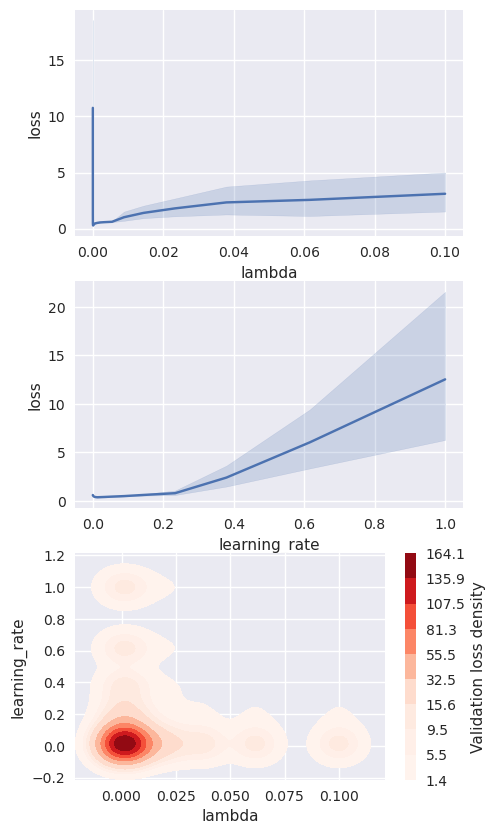

In [444]:
lams = np.logspace(-5, -1, 20) # 1,...,1000
learning_rates = np.logspace(-4, 0, 20) # 10^-5,...,10^-2
hyperparameter_tuning(model3na, model3n_name + '/a/', X_train, y_train_any, model_flag=model_flag, lams=lams, lr=learning_rates)

# linear signal_strength=2, similarity=0.8, nlatent=5
# -- 0.00004, 0.0001, epoch=400 minvalloss = 0.39, anyAUC = 0.946

In [930]:
# Use best hyperparameters for logistic regression
lam = 0.00004
learning_rate = 0.0001
epochs = 400
optimizer = torch.optim.Adam(model3na.parameters(), lr=learning_rate)

stratify=y_train_any
train_dlr, valid_dlr, test_dlr = split_trainvaltest(X_train, y_train_any, stratify, X_test, y_test_any)
numbatches = len(train_dlr)
scheduler = []

# initialize validation loss during training
loss_list = []  # track the loss change when training
iter = 0
min_valid_loss = 10000 # initialize as a large number

Dataset dimensions are (9648, 560) (9648, 1) (2412, 560) (2412, 1) (5940, 560) (5940, 1)


Training Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

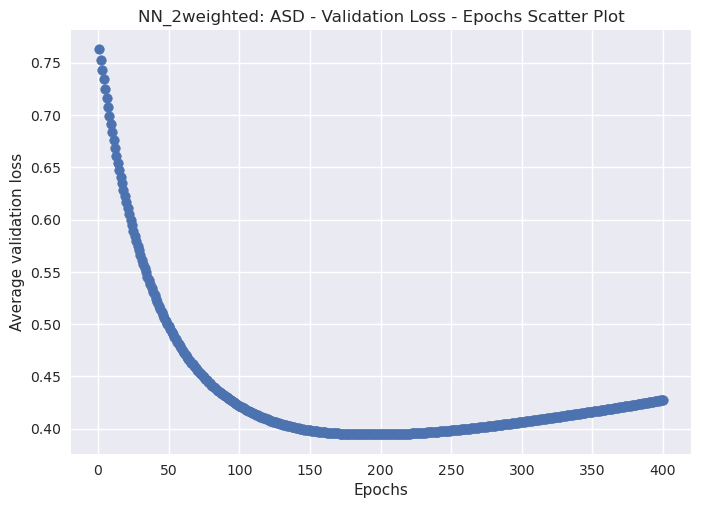

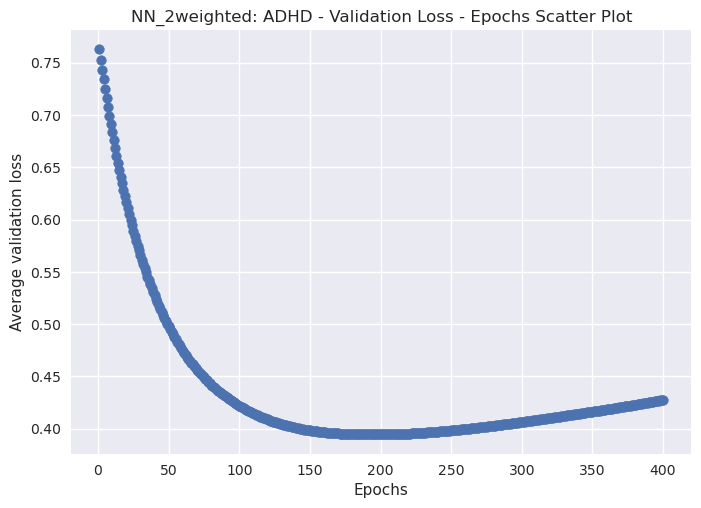

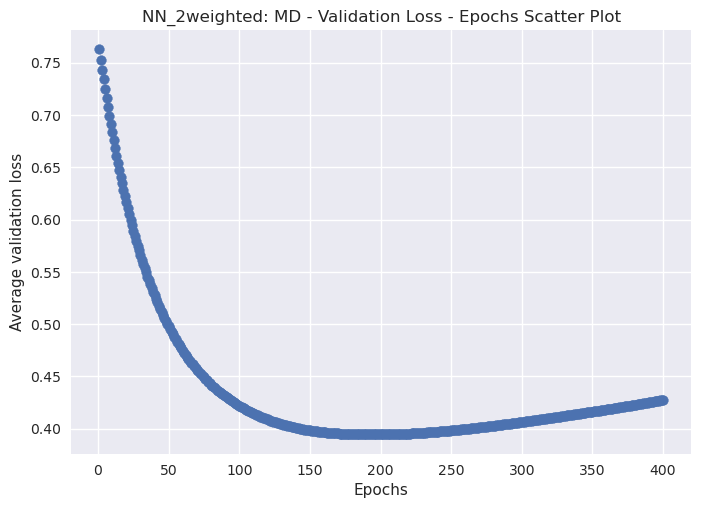

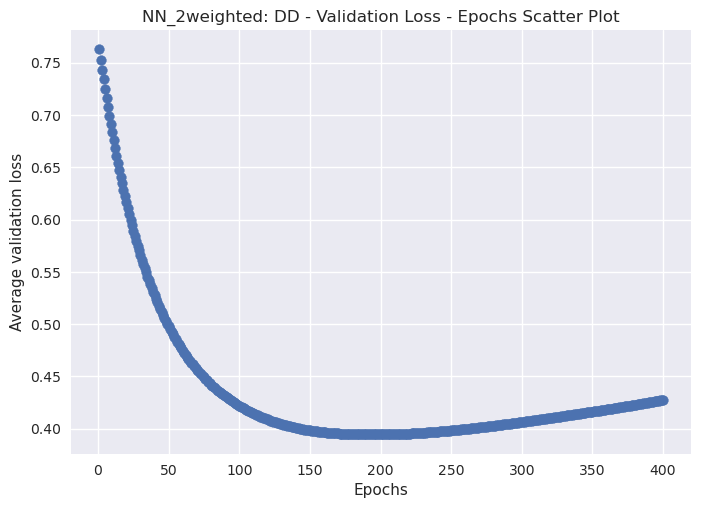

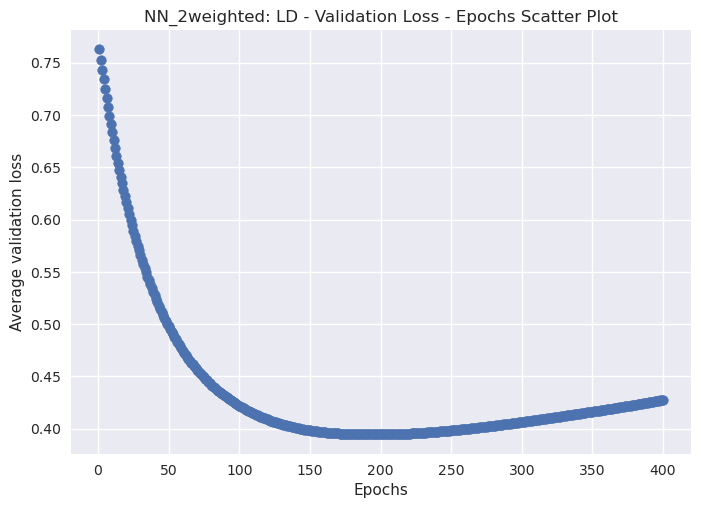

In [931]:
# Train model
model3na, loss_list, min_valid_loss, iter, suffix, plt \
= train_model(model3na, model3n_name, model_flag, model3na_output_dir,train_dlr, valid_dlr,  iter, epochs, loss_list, min_valid_loss, optimizer, scheduler, lam, NDD_labels)

0.3945659250020981
['anyNDD']


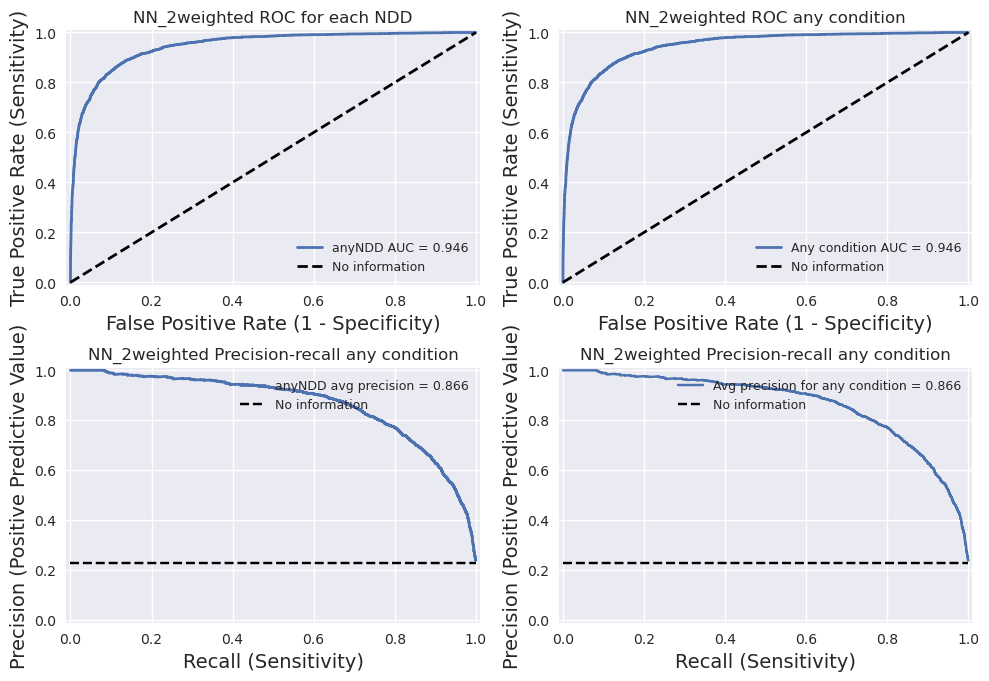

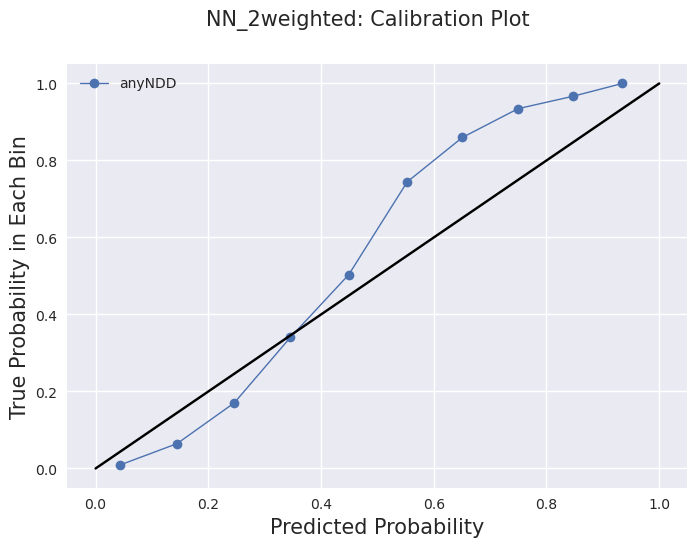

In [932]:
print(min_valid_loss)

# performance on test set (not used)
# y_target, y_pred, plt1, plt2 \
# = get_y_pred(model3na, model3n_name, model3na_output_dir, test_dlr, 'logit', suffix, NDD_label)

# Step b: use prediction from step a as a criteria to go into step b (predict each)
# Combined train and validation set to get prediction
tmp_X_train = X_train.to_numpy().astype(np.float32)
tmp_y_train = y_train_any.to_numpy().astype(np.float32)
tmp_set_train = TransData(xx=tmp_X_train, yy=tmp_y_train)
tmp_train_dlr = DataLoader(tmp_set_train, batch_size=batch_size, shuffle=False)

# output the prediction for training and validation set
y_train_target, y_train_pred, plt1, plt2 \
= get_y_pred(model3na, model3n_name, model3na_output_dir, tmp_train_dlr, 'logit', suffix, ['anyNDD'])

# threshold prediction data to determine which samples goes into step b
y_train_pred = np.array(y_train_pred)

In [1000]:
model3nb = MTLnet(input_dim,len(y_train_each.columns))
model3nb.to(device)
print(model3nb)
model3nb_output_dir = RESULT_DIR + '/' + model3n_name + '/b/'
model_flag = 'L21'

MTLnet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=560, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=5, bias=True)
  )
)


In [1001]:
# start from step b (step a is the same as model3)
W_train = y_train_pred
if not os.path.exists(model3nb_output_dir):
        os.makedirs(model3nb_output_dir)
pickle.dump(y_train_pred, open(model3nb_output_dir + 'y_train_pred.p','wb'))

learning rate loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

The new directory is created!
Best lambda, learning_rate, loss is [0.1        0.03359818 0.00027113]


<module 'matplotlib.pyplot' from '/scratch/wh173/Anaconda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

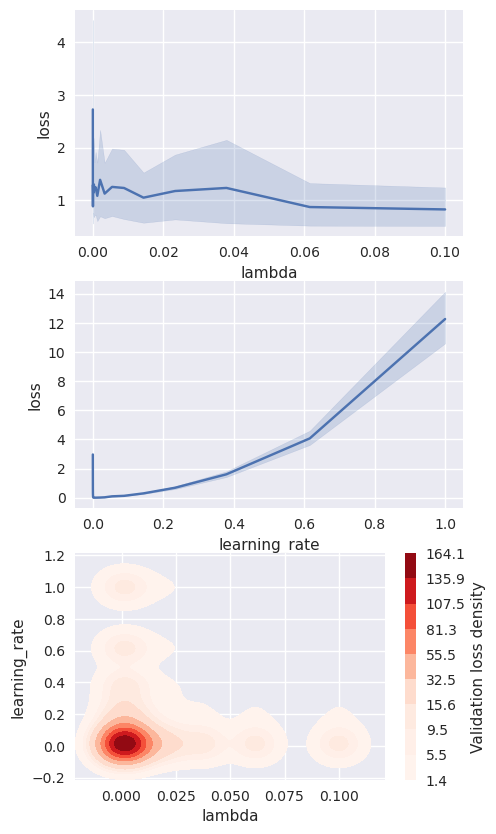

In [991]:
lams = np.logspace(-5, -1, 20) # 1,...,1000
learning_rates = np.logspace(-4, 0, 20) # 10^-5,...,10^-2
hyperparameter_tuning(model3nb, model3n_name + '/b/', X_train*W_train, y_train_each, model_flag, lams=lams, lr=learning_rates)

# linear signal_strength=2, similarity=0.8, nlatent=5, 'L21'
# -- 0.0001, 0.0001, epoch=800, minvalloss = 1.12, ASDAUC = 0.794

In [1002]:
# Use best hyperparameters for logistic regression
lam = 0.0001 # L1 regularization, get from cross-validation
learning_rate = 0.0005
epochs = 800 #  has the lowest validation loss
optimizer = torch.optim.Adam(model3nb.parameters(), lr=learning_rate)

stratify=y_train_each[['ASD_flag','DD_flag','LD_flag']]
train_dlr, valid_dlr, test_dlr = split_trainvaltest(X_train*W_train, y_train_each, stratify, X_test, y_test_each)

# initialize validation loss during training
loss_list = []  # track the loss change when training
iter = 0
min_valid_loss = 10000 # initialize as a large number

Dataset dimensions are (9648, 560) (9648, 5) (2412, 560) (2412, 5) (5940, 560) (5940, 5)


Training Epochs:   0%|          | 0/800 [00:00<?, ?it/s]

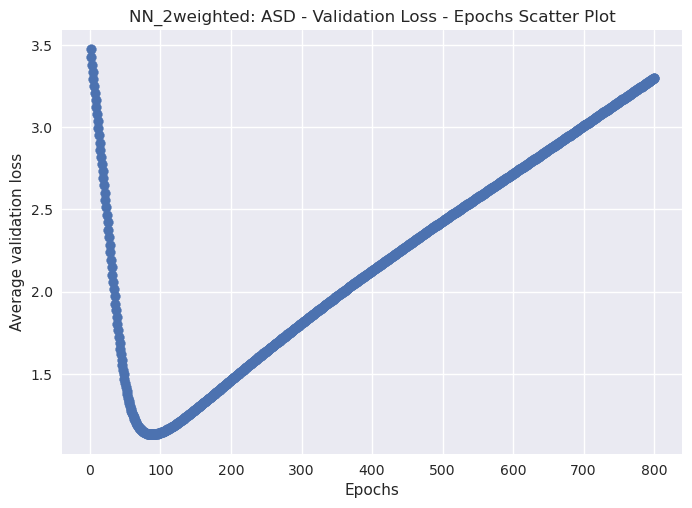

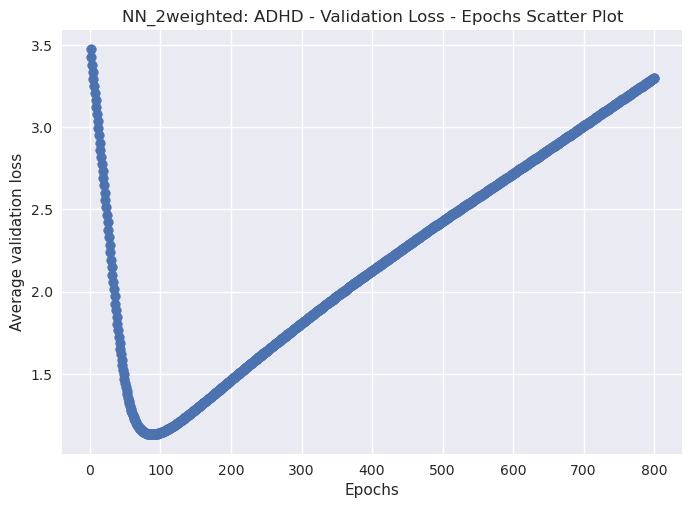

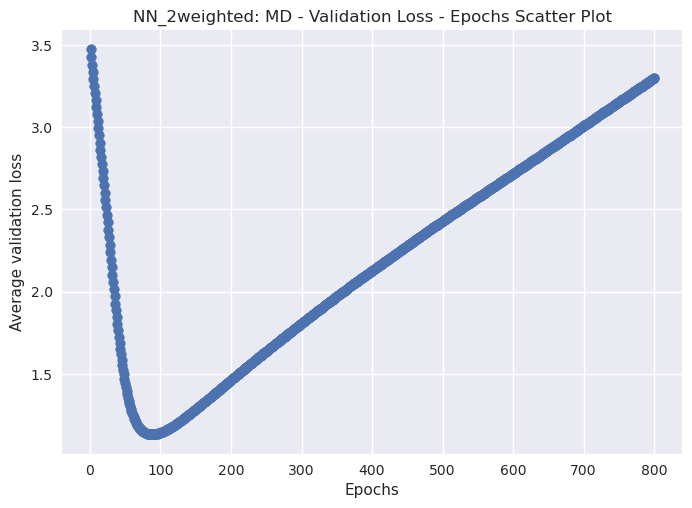

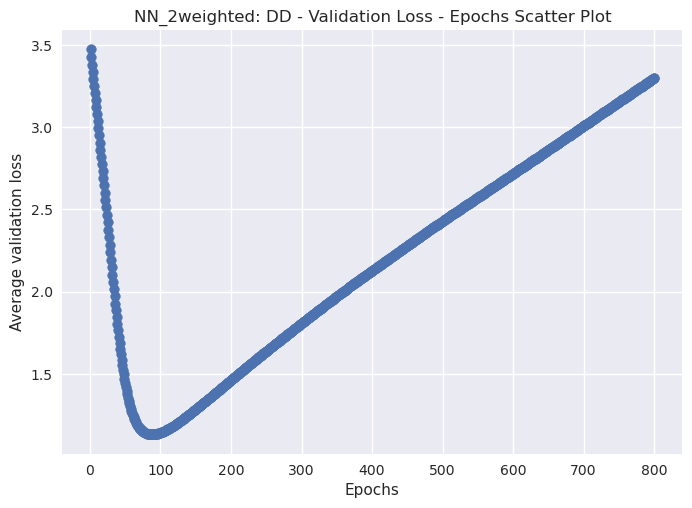

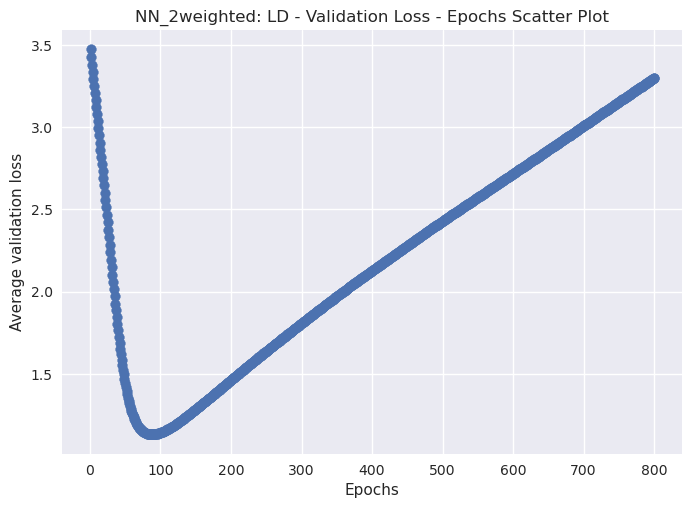

In [1003]:
# Train model
model3nb, loss_list, min_valid_loss, iter, suffix, plt \
= train_model(model3nb, model3n_name, model_flag, model3nb_output_dir, train_dlr, valid_dlr, iter, epochs, loss_list, min_valid_loss, optimizer, scheduler, lam, NDD_labels)

1.132769227027893
['ASD', 'ADHD', 'MD', 'DD', 'LD']


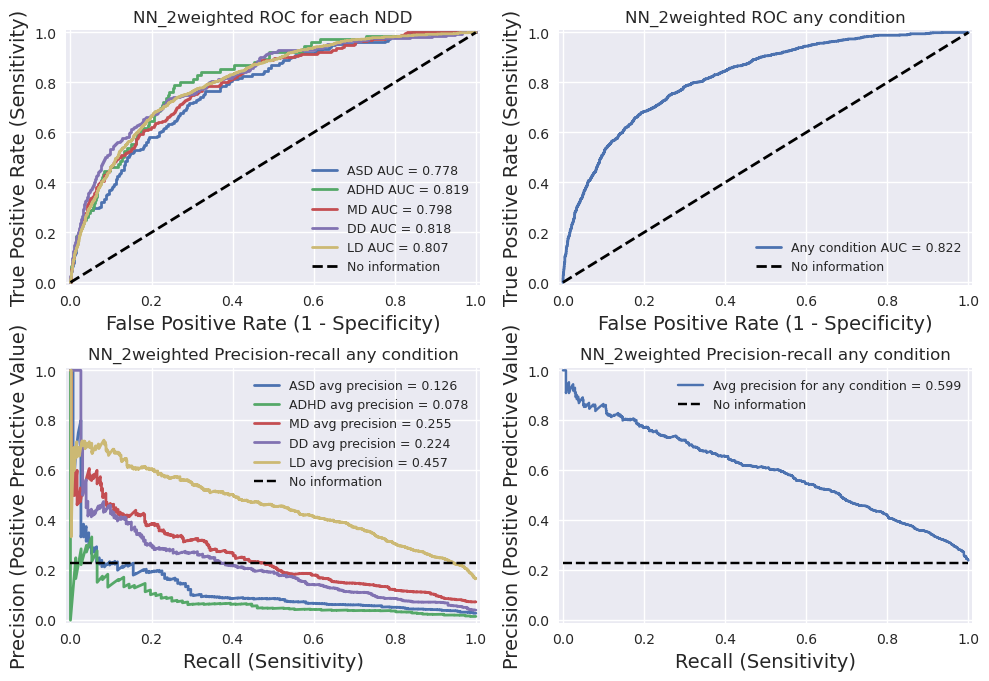

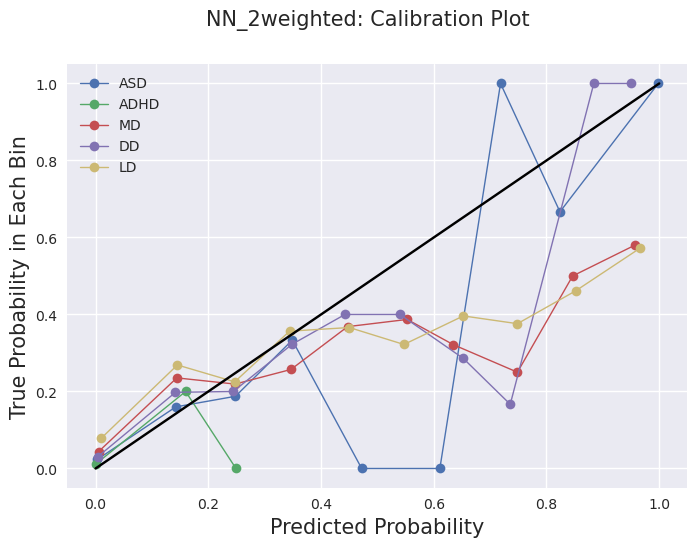

In [1004]:
# test results
print(min_valid_loss)
y_target, y_pred, plt1, plt2 \
= get_y_pred(model3nb, model3n_name, model3nb_output_dir, test_dlr, 'logit', suffix, NDD_labels)

## 1-step CML Model

In [1013]:
model9n_name = 'NN_2in1weighted'
input_dim = len(X_train.columns) # number of input features 
output_dim = len(y_train.columns) # number of output labels: each+NDD
model9n = MTLnet(input_dim,output_dim)
model9n.to(device)
model_flag = '2in1weighted'
model9n_output_dir = RESULT_DIR + '/' + model9n_name
print(model9n)

MTLnet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=560, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=6, bias=True)
  )
)


learning rate loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

regularization lambda loop:   0%|          | 0/20 [00:00<?, ?it/s]

The new directory is created!
Best lambda, learning_rate, loss is [0.00127427 0.08858668 0.        ]


<module 'matplotlib.pyplot' from '/scratch/wh173/Anaconda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

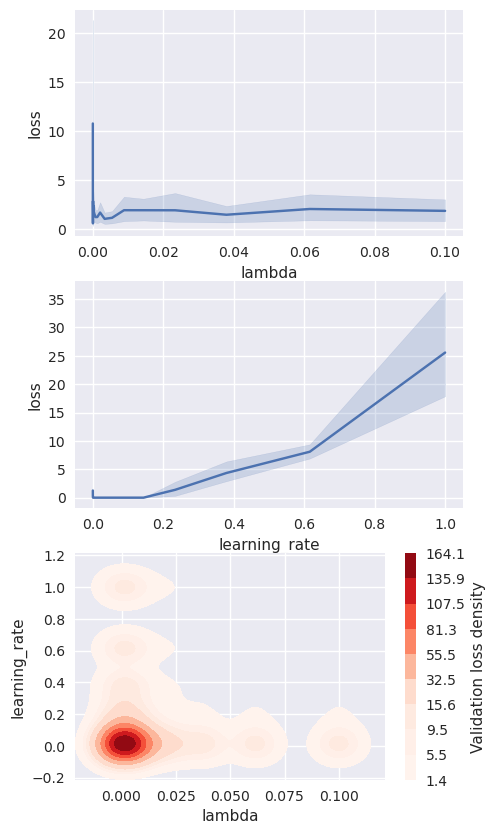

In [955]:
lams = np.logspace(-5, -1, 20) # 1,...,1000
learning_rates = np.logspace(-4, 0, 20) # 10^-5,...,10^-2
# learning rate should not matter too much since this is a convex problem
hyperparameter_tuning(model9n, model9n_name, X_train, y_train, model_flag=model_flag, lams=lams, lr=learning_rates)

# linear signal_strength=2, similarity=0.8, nlatent=5
# -- 0.001, 0.01, minvalloss = 0.364, ASDAUC = 0.811, ANY=0.70

In [1014]:
# Use best hyperparameters
lam = 0.001 #0.0002
learning_rate = 0.005 #0.008

epochs = 400 # has the lowest validation loss    
optimizer = optim.Adam(model9n.parameters(), lr=learning_rate) # switch to Adam 2/21/2023
stratify=y_train[['ASD_flag','LD_flag']]
train_dlr, valid_dlr, test_dlr = split_trainvaltest(X_train, y_train, stratify, X_test, y_test)

numbatches = len(train_dlr)
scheduler = []

# plot validation loss during training
loss_list = []  # track the loss change when training
iter = 0
min_valid_loss = 10000 # initialize as a large number

Dataset dimensions are (9648, 560) (9648, 6) (2412, 560) (2412, 6) (5940, 560) (5940, 6)


Training Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

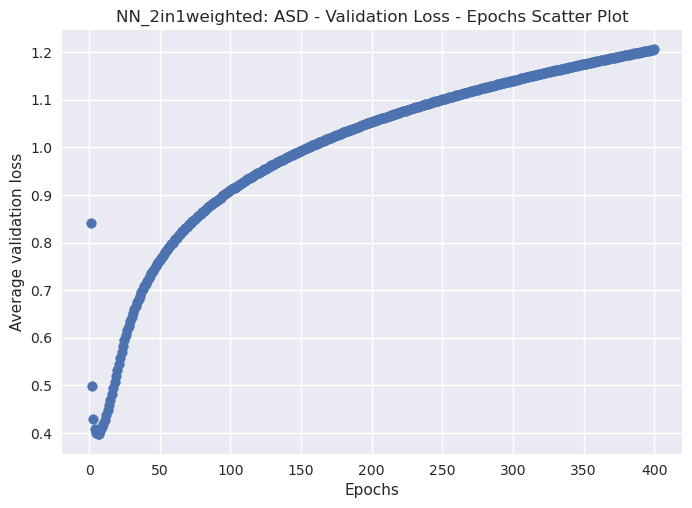

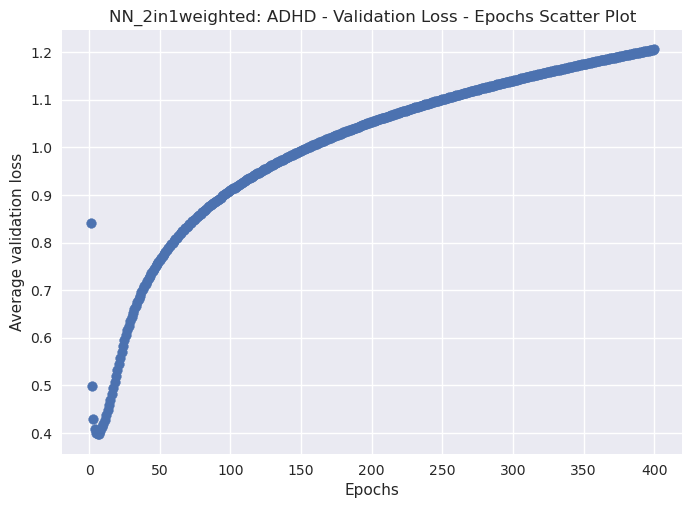

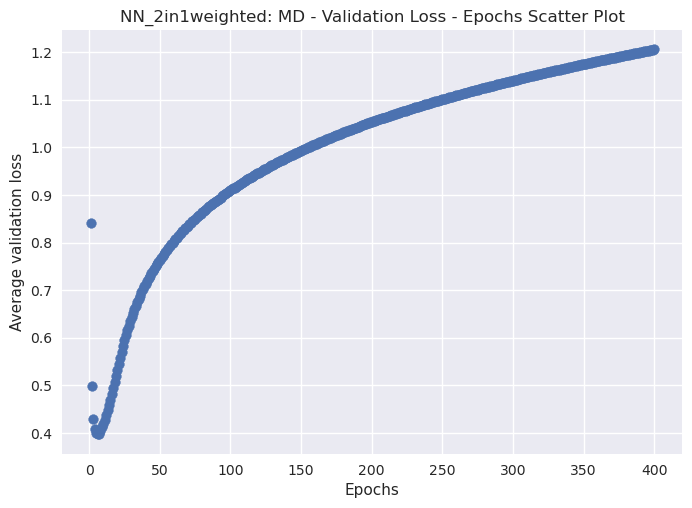

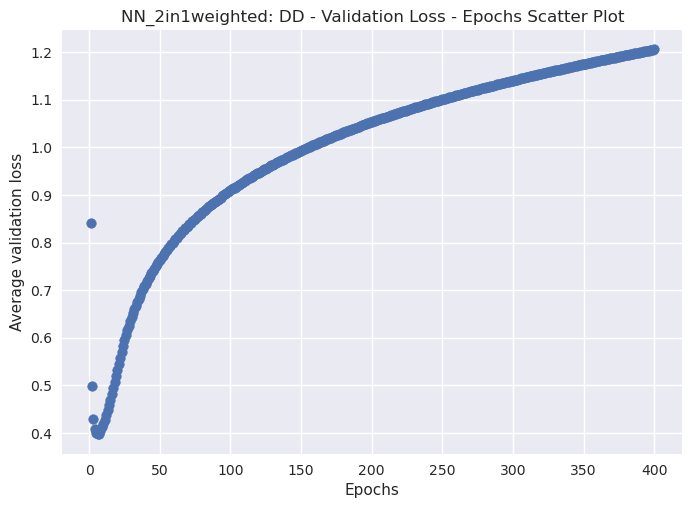

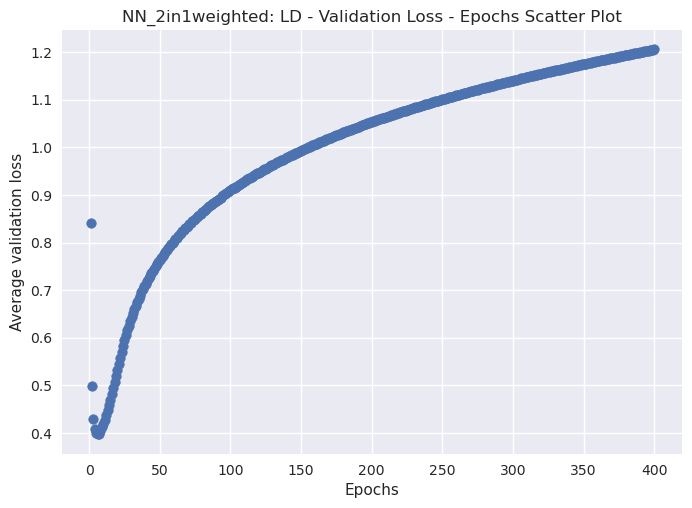

In [1015]:
# Train model
model9n, loss_list, min_valid_loss, iter, suffix, plt \
= train_model(model9n, model9n_name, model_flag, model9n_output_dir, train_dlr, valid_dlr, iter, epochs, loss_list, min_valid_loss, optimizer, scheduler, lam, NDD_labels)

0.39714086055755615
['ASD', 'ADHD', 'MD', 'DD', 'LD']


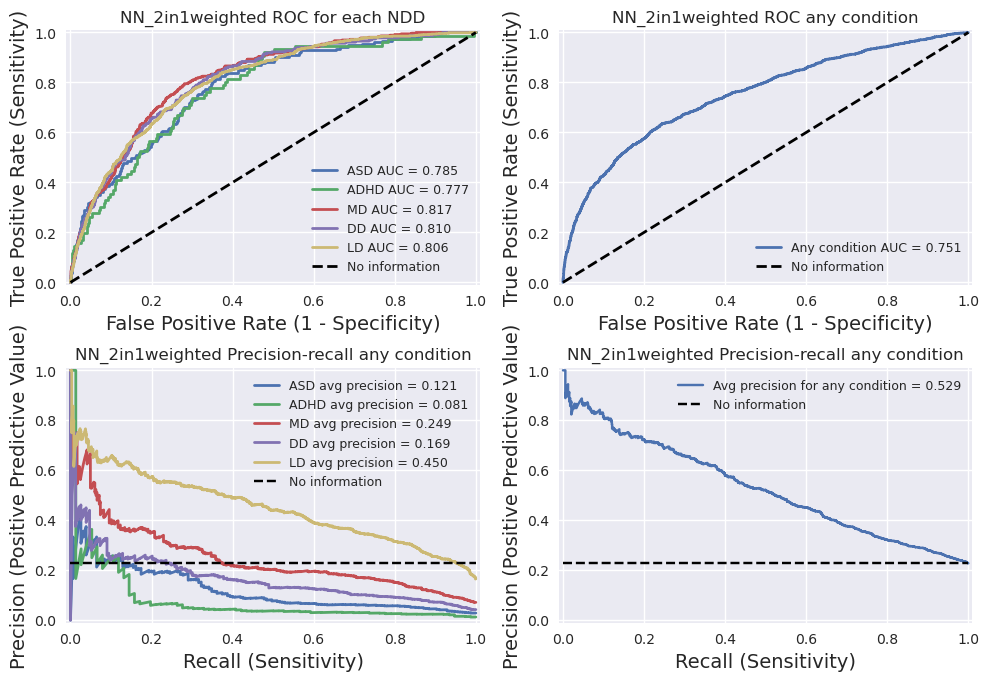

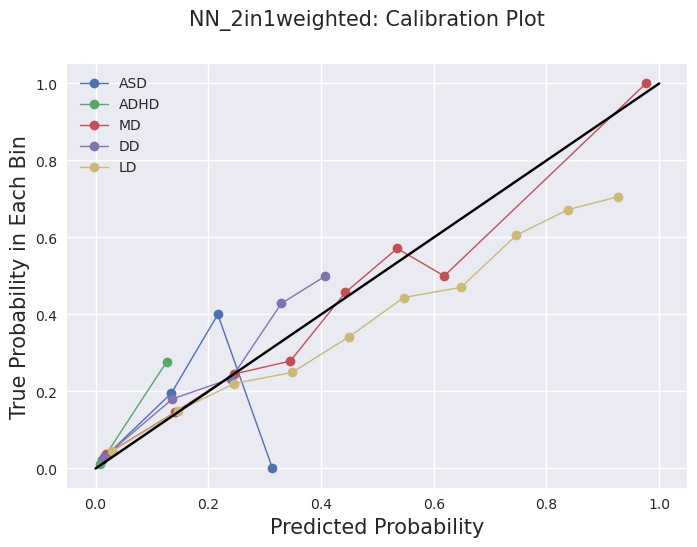

In [1016]:
# Test results
print(min_valid_loss)
y_target, y_pred, plt1, plt2 \
= get_y_pred(model9n, model9n_name, model9n_output_dir, test_dlr, 'logit', suffix, NDD_labels)